In [9]:
%pip install ultralytics


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install kagglehub


Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fatihkgg/affectnet-yolo-format")

print("Path to dataset files:", path)

100%|██████████| 258M/258M [00:11<00:00, 22.9MB/s] 

Extracting files...


Path to dataset files: /home/sagemaker-user/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2


In [6]:
%cp -r /home/sagemaker-user/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2/YOLO_format .

In [1]:
import os
import random
from ultralytics.nn.tasks import DetectionModel
import torch.serialization
import yaml
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import numpy as np
from pathlib import Path
from graphviz import Digraph
import torch.nn as nn

In [12]:
# === Configuration ===
DATA_YAML = 'data.yaml' 
EPOCHS = 300
IMG_SIZE = 640
BATCH = 8
PATIENCE = 10
DEVICE = 0
WORKERS = 8
RESUME_MODEL = False

In [13]:
def load_data_yaml(path):
    """Load and return YAML content."""
    with open(path, 'r') as f:
        data = yaml.safe_load(f)
    return data

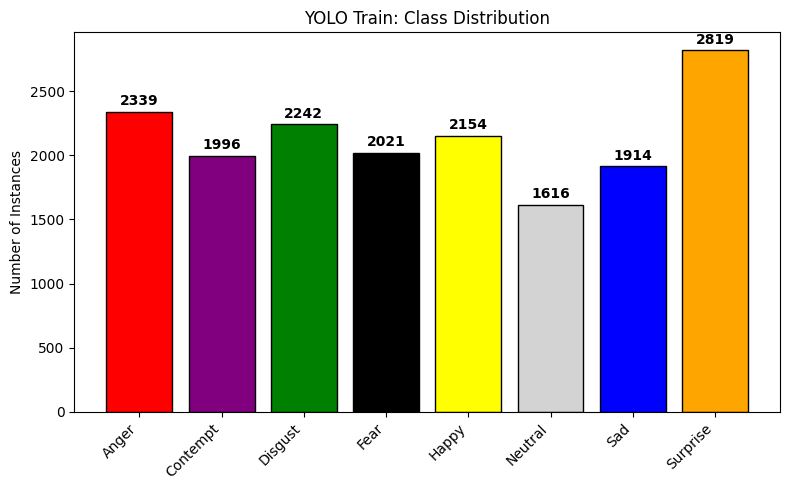

In [ ]:

# --- load and count ---
data       = load_data_yaml(DATA_YAML)
classes    = data["names"]
images_dir = data.get('train')
labels_dir = images_dir.replace('/images', '/labels')

counts = {i: 0 for i in range(len(classes))}
for fname in os.listdir(labels_dir):
    if not fname.endswith('.txt'):
        continue
    with open(os.path.join(labels_dir, fname)) as f:
        for line in f:
            cls = int(line.split()[0])
            counts[cls] += 1

# --- prepare plotting data ---
names  = [classes[i] for i in sorted(counts.keys())]
values = [counts[i]           for i in sorted(counts.keys())]

colors_map = {
    "Anger":   "red",
    "Contempt":"purple",
    "Disgust": "green",
    "Fear":    "black",
    "Happy":   "yellow",
    "Neutral": "lightgrey",
    "Sad":     "blue",
    "Surprise":"orange",
}

# for each name pick the bar color, and a contrasting text color
bar_colors  = [colors_map[name] for name in names]

# --- plot ---
plt.figure(figsize=(8, 5))
bars = plt.bar(names, values, color=bar_colors, edgecolor='black')

# annotate counts
for bar, val in zip(bars, values):
    x = bar.get_x() + bar.get_width() / 2
    y = val + max(values) * 0.01  # small offset above bar
    plt.text(
        x, y, str(val),
        ha='center', va='bottom',
        color="black",
        fontweight='bold'
    )

plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Instances')
plt.title('YOLO Train: Class Distribution')
plt.gca().set_facecolor('white')  # ensure white background
plt.tight_layout()
plt.show()

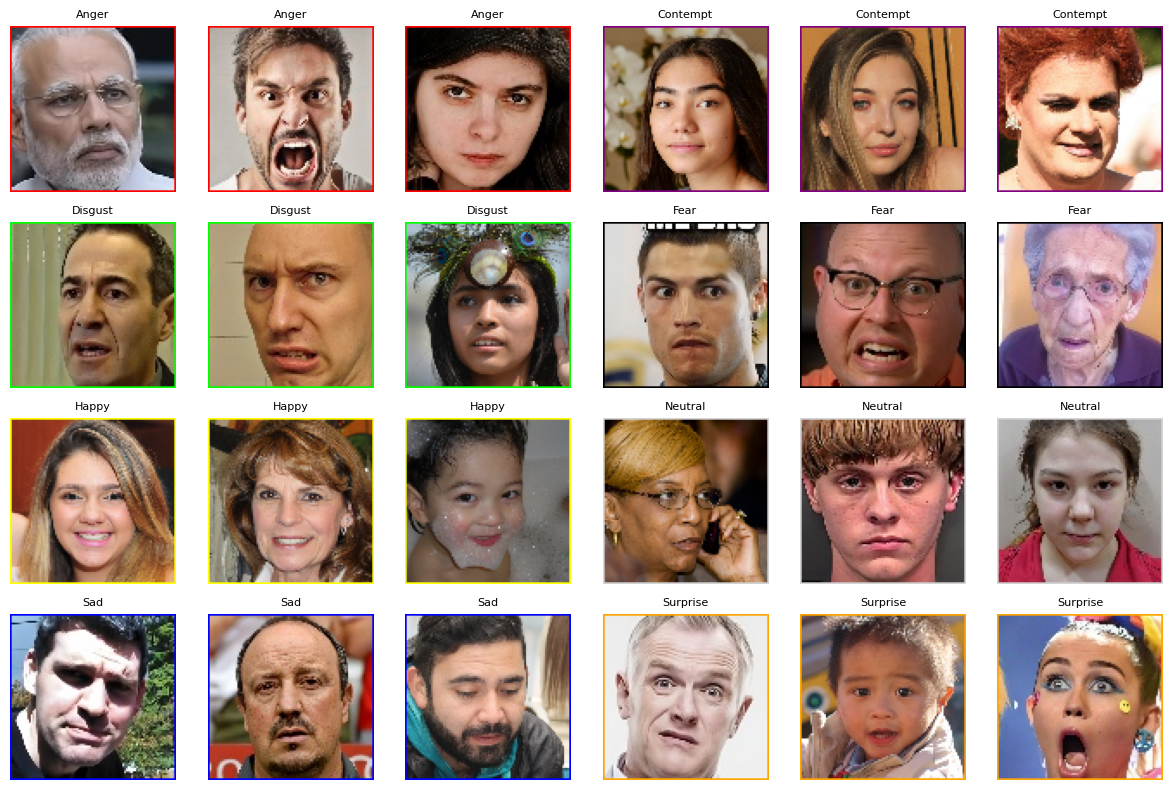

In [30]:
import os
import cv2
import yaml
import random
import matplotlib.pyplot as plt

def show_multiple_yolo_class_samples_from_yaml(data_yaml_path, samples_per_class=2, img_exts=['.jpg', '.jpeg', '.png'], grid_cols=6):
    """
    Displays random sample images per class using YOLO dataset defined in a data.yaml file.
    Designed for small image size (e.g. 96x96), with RGB-coloured bounding boxes and random sampling.
    """
    # RGB colour map for Matplotlib
    colors_map = {
        "Anger":    (255, 0, 0),
        "Contempt":(128, 0, 128),
        "Disgust": (0, 255, 0),
        "Fear":    (0, 0, 0),
        "Happy":   (255, 255, 0),
        "Neutral": (211, 211, 211),
        "Sad":     (0, 0, 255),
        "Surprise":(255, 165, 0)
    }

    # Set random seed
    random.seed(None)

    # Load data.yaml
    with open(data_yaml_path, 'r') as f:
        data_cfg = yaml.safe_load(f)

    train_img_dir = data_cfg['train']
    label_dir = train_img_dir.replace('images', 'labels')
    classes = data_cfg['names']
    num_classes = len(classes)

    class_samples = {i: [] for i in range(num_classes)}

    # Scan all label files and collect image-label pairs by class
    for fname in os.listdir(label_dir):
        if not fname.endswith('.txt'):
            continue
        label_path = os.path.join(label_dir, fname)
        img_base = os.path.splitext(fname)[0]
        for ext in img_exts:
            img_path = os.path.join(train_img_dir, img_base + ext)
            if os.path.exists(img_path):
                break
        else:
            continue  # No image match found

        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                class_samples[class_id].append((img_path, label_path))

    # Randomly pick N samples per class
    selected_samples = []
    for class_id, samples in class_samples.items():
        chosen = random.sample(samples, min(samples_per_class, len(samples)))
        selected_samples.extend([(class_id, img_path, label_path) for img_path, label_path in chosen])

    # Grid setup
    total_samples = len(selected_samples)
    grid_rows = (total_samples + grid_cols - 1) // grid_cols
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2))
    axes = axes.flatten()

    for idx, (class_id, img_path, label_path) in enumerate(selected_samples):
        image = cv2.imread(img_path)
        h, w = image.shape[:2]

        # Get class name and RGB colour
        class_name = classes[class_id]
        rect_color = colors_map.get(class_name, (255, 255, 255))

        # Draw rectangles in OpenCV (BGR) before RGB conversion
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cid, x, y, box_w, box_h = map(float, parts)
                if int(cid) == class_id:
                    x1 = int((x - box_w / 2) * w)
                    y1 = int((y - box_h / 2) * h)
                    x2 = int((x + box_w / 2) * w)
                    y2 = int((y + box_h / 2) * h)
                    # Convert RGB to BGR for OpenCV
                    bgr_color = rect_color[::-1]
                    cv2.rectangle(image, (x1, y1), (x2, y2), bgr_color, 1)

        # Convert image to RGB for display
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image)
        axes[idx].axis('off')
        axes[idx].set_title(class_name, fontsize=8)

    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
show_multiple_yolo_class_samples_from_yaml('data.yaml', samples_per_class=3)


In [ ]:
from ultralytics import YOLO

# ---------------- Hyper‑parameters -----------------
EPOCHS = 500
BATCH  = 32
IMGSZ  = 96
DEVICE = '0'
# ---------------------------------------------------

model = YOLO("./runs/train/affectnet_yolov11/weights/last.pt")


In [ ]:
results = model.train(
    data='./YOLO_format/data.yaml',
    epochs=500,
    imgsz=96,
    batch=32,
    device='0',
    workers=8,
    project='runs/train',
    name='affectnet_yolov11'
    ,resume=True
)

Ultralytics 8.3.111 🚀 Python-3.12.9 torch-2.5.1 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: task=detect, mode=train, model=runs/train/affectnet_yolov113/weights/last.pt, data=./YOLO_format/data.yaml, epochs=500, time=None, patience=100, batch=32, imgsz=96, save=True, save_period=-1, cache=False, device=0, workers=8, project=runs/train, name=affectnet_yolov113, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=runs/train/affectnet_yolov113/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False

E0000 00:00:1745143306.414419   11557 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745143306.420153   11557 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /home/sagemaker-user/YOLO_format/train/labels.cache... 17101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17101/17101 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 173.7±40.0 MB/s, size: 5.1 KB)


val: Scanning /home/sagemaker-user/YOLO_format/valid/labels.cache... 5406 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5406/5406 [00:00<?, ?it/s]


Plotting labels to runs/train/affectnet_yolov113/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Resuming training runs/train/affectnet_yolov113/weights/last.pt from epoch 476 to 500 total epochs


2025/04/20 10:01:56 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/04/20 10:01:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/04/20 10:01:56 WARNING mlflow.utils.autologging_utils: MLflow keras autologging is known to be compatible with 3.0.2 <= keras <= 3.8.0, but the installed version is 3.9.0. If you encounter errors during autologging, try upgrading / downgrading keras to a compatible version, or try upgrading MLflow.
2025/04/20 10:01:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/04/20 10:01:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/20 10:01:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/20 10:01:57 INFO mlflow.tracking.fluent: Autologging succ

MLflow: logging run_id(28a131a8f3fb4191a729f4884d92c619) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 96 train, 96 val
Using 4 dataloader workers
Logging results to runs/train/affectnet_yolov113
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    476/500     0.211G    0.06904      1.042     0.8879         39         96: 100%|██████████| 535/535 [00:43<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:14<00:00,  5.90it/s]

                   all       5406       5406      0.697      0.753      0.788      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    477/500     0.232G    0.06823       1.04      0.887         37         96: 100%|██████████| 535/535 [00:43<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.25it/s]

                   all       5406       5406      0.697      0.753      0.788      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    478/500     0.232G    0.06863      1.041     0.8871         41         96: 100%|██████████| 535/535 [00:44<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.15it/s]

                   all       5406       5406      0.697      0.754      0.787      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    479/500     0.242G        inf      1.039     0.8876         36         96: 100%|██████████| 535/535 [00:43<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.14it/s]


                   all       5406       5406      0.695      0.758      0.787      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    480/500     0.242G        inf      1.044     0.8874         38         96: 100%|██████████| 535/535 [00:43<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.21it/s]

                   all       5406       5406      0.695      0.759      0.787      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    481/500     0.242G    0.06762      1.045      0.889         47         96: 100%|██████████| 535/535 [00:43<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:14<00:00,  6.06it/s]

                   all       5406       5406      0.694      0.759      0.787      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    482/500     0.242G     0.0682      1.035     0.8866         45         96: 100%|██████████| 535/535 [00:43<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.21it/s]

                   all       5406       5406      0.694       0.76      0.786      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    483/500     0.242G     0.0678       1.04     0.8876         35         96: 100%|██████████| 535/535 [00:43<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.24it/s]

                   all       5406       5406      0.694       0.76      0.785      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    484/500     0.242G    0.06786      1.034     0.8875         39         96: 100%|██████████| 535/535 [00:44<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.21it/s]


                   all       5406       5406      0.694       0.76      0.785      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    485/500     0.242G    0.06808      1.045     0.8873         41         96: 100%|██████████| 535/535 [00:44<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.16it/s]


                   all       5406       5406      0.693      0.761      0.785      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    486/500     0.242G    0.06736      1.038      0.887         46         96: 100%|██████████| 535/535 [00:44<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.30it/s]

                   all       5406       5406      0.693      0.761      0.784      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    487/500     0.242G    0.06759      1.031     0.8879         44         96: 100%|██████████| 535/535 [00:43<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.27it/s]


                   all       5406       5406      0.691      0.763      0.784      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    488/500     0.242G        inf      1.034     0.8872         38         96: 100%|██████████| 535/535 [00:43<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:14<00:00,  6.01it/s]


                   all       5406       5406      0.692      0.762      0.783      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    489/500     0.242G    0.06674       1.03      0.887         41         96: 100%|██████████| 535/535 [00:43<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.20it/s]


                   all       5406       5406      0.691      0.763      0.782      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    490/500     0.242G    0.06634      1.037     0.8867         37         96: 100%|██████████| 535/535 [00:44<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.08it/s]

                   all       5406       5406      0.692      0.762      0.782      0.782


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    491/500     0.242G    0.05031     0.5959     0.9056         13         96: 100%|██████████| 535/535 [00:42<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.19it/s]


                   all       5406       5406      0.691      0.762      0.781      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    492/500     0.242G     0.0458     0.5544     0.9023         13         96: 100%|██████████| 535/535 [00:42<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.14it/s]


                   all       5406       5406      0.691      0.761      0.781      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    493/500     0.242G        inf     0.5512     0.9037         13         96: 100%|██████████| 535/535 [00:43<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.13it/s]

                   all       5406       5406      0.693       0.76      0.781      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    494/500     0.242G    0.04416     0.5461     0.9031         13         96: 100%|██████████| 535/535 [00:41<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.09it/s]

                   all       5406       5406      0.693      0.756       0.78       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    495/500     0.242G    0.04422     0.5454     0.9013         13         96: 100%|██████████| 535/535 [00:41<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.19it/s]

                   all       5406       5406      0.702      0.746       0.78       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    496/500     0.242G    0.04394     0.5367     0.9013         13         96: 100%|██████████| 535/535 [00:42<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.12it/s]

                   all       5406       5406      0.703      0.745      0.781      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    497/500     0.242G    0.04283     0.5314     0.9037         13         96: 100%|██████████| 535/535 [00:42<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.19it/s]


                   all       5406       5406      0.705      0.744      0.781      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    498/500     0.252G     0.0439     0.5333     0.9032         13         96: 100%|██████████| 535/535 [00:42<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.19it/s]


                   all       5406       5406      0.703      0.746      0.781      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    499/500     0.252G    0.04206     0.5288     0.9016         13         96: 100%|██████████| 535/535 [00:42<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.20it/s]


                   all       5406       5406      0.704      0.746      0.782      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    500/500     0.252G    0.04225     0.5238      0.903         13         96: 100%|██████████| 535/535 [00:43<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:13<00:00,  6.15it/s]

                   all       5406       5406      0.704      0.744      0.783      0.783



25 epochs completed in 0.399 hours.
Optimizer stripped from runs/train/affectnet_yolov113/weights/last.pt, 5.5MB
Optimizer stripped from runs/train/affectnet_yolov113/weights/best.pt, 5.5MB

Validating runs/train/affectnet_yolov113/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.12.9 torch-2.5.1 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n summary (fused): 100 layers, 2,583,712 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:16<00:00,  5.28it/s]


                   all       5406       5406      0.699      0.746      0.792      0.792
                 Anger        712        712      0.629      0.794      0.783      0.783
              Contempt        618        618      0.687      0.793      0.827      0.827
               Disgust        672        672      0.682      0.695      0.764      0.764
                  Fear        622        622      0.744      0.698      0.797      0.797
                 Happy        791        791      0.843       0.88       0.94       0.94
               Neutral        514        514      0.634       0.64      0.675      0.675
                   Sad        603        603      0.674      0.657      0.724      0.724
              Surprise        874        874      0.701      0.814      0.824      0.824
Speed: 0.0ms preprocess, 0.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/train/affectnet_yolov113
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo setti

AttributeError: 'DetMetrics' object has no attribute 'best'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class.
        names (dict): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
    